In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
folder_path = r'C:\Users\lenov\OneDrive\Bureau\mlops_interpretability\data'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dfs = []

for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df['source_file'] = file  # Ajoute le nom du fichier
    dfs.append(df)
    
combined_df = pd.concat(dfs, ignore_index=True)

combined_df['is_home_pitcher'] = combined_df['inning_topbot'].apply(lambda x: 1 if x == 'Top' else 0)

C:\Users\lenov\AppData\Local\Temp\ipykernel_26172\917689801.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)


In [3]:
variables = [
    'description',
    'player_name',
    'is_home_pitcher',

    #'home_team', 'away_team',
    # Lancer / release
    "release_speed",          # Vitesse de la balle au moment du lâcher (mph)
    "release_pos_x",          # Position horizontale du point de release (feet)
    "release_pos_y",          # Position verticale (distance depuis le monticule ou le sol)
    "release_pos_z",          # Hauteur du point de release (feet)
    "release_extension",      # Distance du pied du monticule à la main au moment du release (feet)
    "release_spin_rate",      # Vitesse de rotation de la balle au release (rpm)              
    "spin_axis",              # Idem spin_dir (peut être redondant)
    "p_throws",               # Bras du lanceur (R = droitier, L = gaucher)
    "pitch_name",             # Type de pitch (fastball, slider, curve, etc.)
    "pitch_number",           # Ordre du pitch dans l'AB

    # Trajectoire / physique
    "vx0", "vy0", "vz0",      # Vitesse de la balle sur les axes x, y, z au release (feet/sec)
    "ax", "ay", "az",         # Accélérations sur les axes x, y, z (gravité + spin)
    "pfx_x", "pfx_z",         # Déviation latérale (x) et verticale (z)
    "effective_speed",        # Vitesse perçue par le frappeur
    "sz_top", "sz_bot",       # Bornes supérieures et inférieures de la zone de strike
    "arm_angle",    # Angle du bras du lanceur au release,

    'game_type',
    'stand',

    # Contexte du joueur
    "age_bat",                # Âge du batteur
    "age_bat_legacy",         # Âge lors de la première saison MLB
    "n_priorpa_thisgame_player_at_bat",  # Nombre d'AB précédents pour ce joueur dans le match

    # Champ / défense
    "of_fielding_alignment",  # Alignement des joueurs de champ extérieur
    "if_fielding_alignment",  # Alignement des joueurs de champ intérieur

    # Compte / situation
    "balls", "strikes",       # Compte courant du batteur
    "outs_when_up",           # Nombre de retraits lors de l'AB
    "inning", "inning_topbot",# Manche et top/bottom (haut/bas)
    "home_score", "away_score", # Score courant
    # "home_score_diff",        # Différence score maison - extérieur
    "at_bat_number"           # Numéro d'AB dans le match
]

In [4]:
df_ml = combined_df.loc[:, variables]
df_ml.dropna(inplace = True)

In [5]:
cols_to_convert = [
    'pitch_number',
    'age_bat',
    'age_bat_legacy',
    'n_priorpa_thisgame_player_at_bat',
    'balls',
    'strikes',
    'outs_when_up',
    'inning',
    'home_score',
    'away_score',
    'at_bat_number'
]


for col in df_ml[cols_to_convert] : 
    df_ml[col] = df_ml[col].astype(float)

In [6]:
mapping = {
    'called_strike': 'strike',
    'swinging_strike': 'strike',
    'swinging_strike_blocked': 'strike',
    'blocked_ball': 'other',
    'foul_tip': 'foul',
    'foul_bunt': 'foul',
    'missed_bunt': 'other',
    'bunt_foul_tip': 'foul',
    'pitchout': 'other',
    'ball': 'ball',
    'foul': 'foul',
    'hit_into_play': 'in_play',
    'hit_by_pitch': 'other'
}

df_ml['description_grouped'] = df_ml.description.replace(mapping)
print(df_ml.description_grouped.value_counts())

df_ml.drop('description', axis = 1, inplace = True)

df_ml_final = df_ml.loc[df_ml['description_grouped'] != 'other']

description_grouped
ball       8824
strike     7677
foul       5173
in_play    4602
other       587
Name: count, dtype: int64


In [7]:
y = df_ml_final['description_grouped']
X = df_ml_final.drop(columns = 'description_grouped')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [8]:
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
numeric_columns = [col for col in X_train.columns if col not in categorical_columns]

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit sur X_train et transformer train et test
X_train_cat = pd.DataFrame(
    ohe.fit_transform(X_train[categorical_columns]),
    columns=ohe.get_feature_names_out(categorical_columns),
    index=X_train.index
)

X_test_cat = pd.DataFrame(
    ohe.transform(X_test[categorical_columns]),
    columns=ohe.get_feature_names_out(categorical_columns),
    index=X_test.index
)


X_train_final = pd.concat([X_train[numeric_columns], X_train_cat], axis=1)
X_test_final  = pd.concat([X_test[numeric_columns], X_test_cat], axis=1)

print(X_train_final.shape)
print(X_test_final.shape)

(21020, 66)
(5256, 66)


In [9]:
from sklearn.preprocessing import LabelEncoder

# Créer l'encodeur
le = LabelEncoder()

# Fit et transformer les labels
y_train_encoded = le.fit_transform(y_train)
y_test_encoded  = le.transform(y_test)

# Vérifier la correspondance
print(list(le.classes_))  # ['ball', 'foul', 'in_play', 'strike']

['ball', 'foul', 'in_play', 'strike']


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,       # nombre d'arbres
    max_depth=None,         # profondeur (None = jusqu’à pureté)
    min_samples_split=2,    # min de samples pour splitter
    min_samples_leaf=1,     # min de samples par feuille
    max_features='sqrt',    # nombre de features utilisées à chaque split
    bootstrap=True,         # tirage avec remise
    random_state=42,        # reproductibilité
    n_jobs=-1               # utiliser tous les cœurs CPU
)

rf_model.fit(X_train_final, y_train_encoded)
rf_preds = rf_model.predict(X_test_final)


print("Accuracy:", accuracy_score(y_test_encoded, rf_preds))
print(classification_report(y_test_encoded, rf_preds))

Accuracy: 0.4895357686453577
              precision    recall  f1-score   support

           0       0.59      0.76      0.66      1744
           1       0.39      0.30      0.34      1033
           2       0.34      0.14      0.20       967
           3       0.44      0.53      0.48      1512

    accuracy                           0.49      5256
   macro avg       0.44      0.43      0.42      5256
weighted avg       0.46      0.49      0.46      5256



In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.2,
    reg_lambda=1.0,
    random_state=42,
    tree_method='hist', # ou 'gpu_hist' si GPU dispo
    objective='multi:softprob',
    num_class = 4 
    #eval_metric='mlogloss'
)



xgb_model.fit(X_train_final, y_train_encoded)
# -------------------------------
# -------------------------------
y_pred = xgb_model.predict(X_test_final)
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred))

Accuracy: 0.5504185692541856
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1744
           1       0.40      0.35      0.37      1033
           2       0.39      0.28      0.32       967
           3       0.49      0.58      0.53      1512

    accuracy                           0.55      5256
   macro avg       0.50      0.50      0.50      5256
weighted avg       0.54      0.55      0.54      5256



### Sauvgarde des artifacts

In [12]:
parent_dir = os.path.dirname(os.getcwd())

# Chemin complet pour le dossier artifacts
artifacts_dir = os.path.join(parent_dir, "artifacts")

# Créer le dossier s'il n'existe pas déjà
os.makedirs(artifacts_dir, exist_ok=True)

print(f"Dossier artifacts créé ici : {artifacts_dir}")

joblib.dump(xgb_model, os.path.join(artifacts_dir, "xgb_pitch_model.joblib"))
joblib.dump(rf_model, os.path.join(artifacts_dir, "rf_pitch_model.joblib"))
joblib.dump(ohe, os.path.join(artifacts_dir, "ohe_encoder.joblib"))
joblib.dump(le, os.path.join(artifacts_dir, "label_encoder.joblib"))

Dossier artifacts créé ici : C:\Users\lenov\OneDrive\Bureau\mlops_interpretability\artifacts


['C:\\Users\\lenov\\OneDrive\\Bureau\\mlops_interpretability\\artifacts\\label_encoder.joblib']

# Interprétabilité RandomForest

In [14]:
import shap
explainer_rf = shap.TreeExplainer(rf_model, data = X_train_final.iloc[:3000, :])
# très rapide, une ségonde 

In [15]:
shap_values_rf = explainer_rf.shap_values(X_test_final.iloc[:1000, :])
# 45 minutes
# la durée du calcule depend ici du nombre d'arbres car par default la solution retenur est 
# heature_perturbatio = "tree_path_dependent"

100%|===================| 3999/4000 [45:14<00:00]        

In [18]:
explainer_rf.expected_value

array([0.35738, 0.21418, 0.15844, 0.27   ])

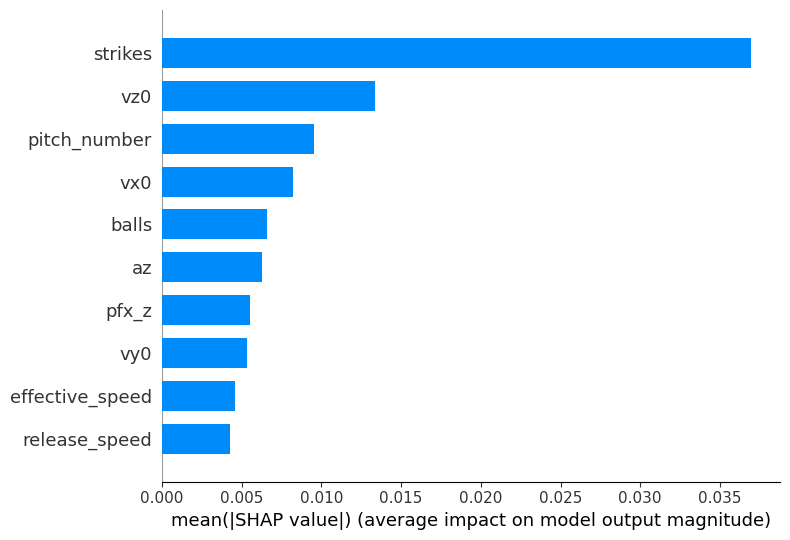

In [16]:
shap.summary_plot(shap_values_rf[:, :, 3], X_test_final.iloc[:1000, :], plot_type="bar", max_display=10)

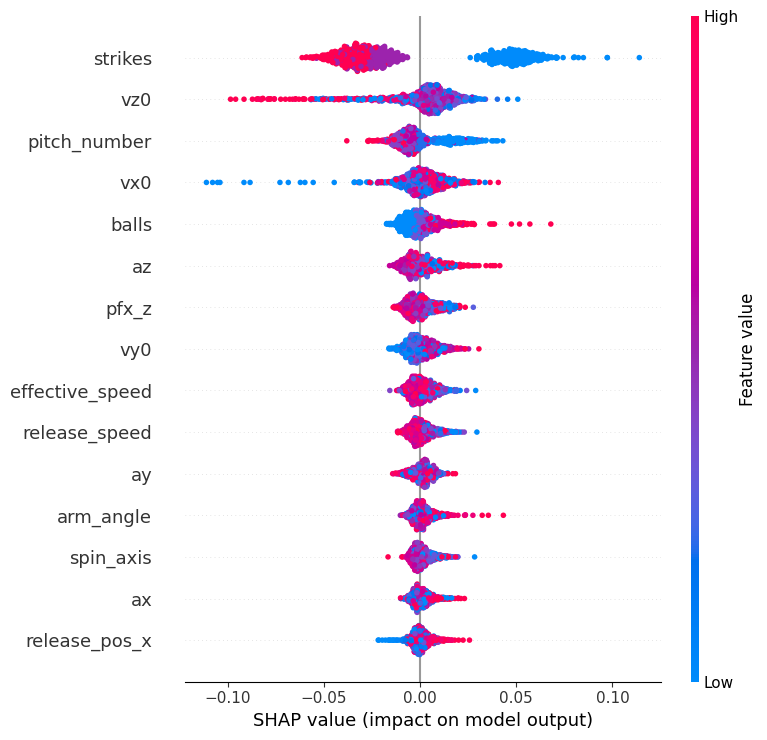

In [24]:
shap.summary_plot(shap_values_rf[:, :, 3], X_test_final.iloc[:1000, :], feature_names=X_train_final.columns, max_display=15)

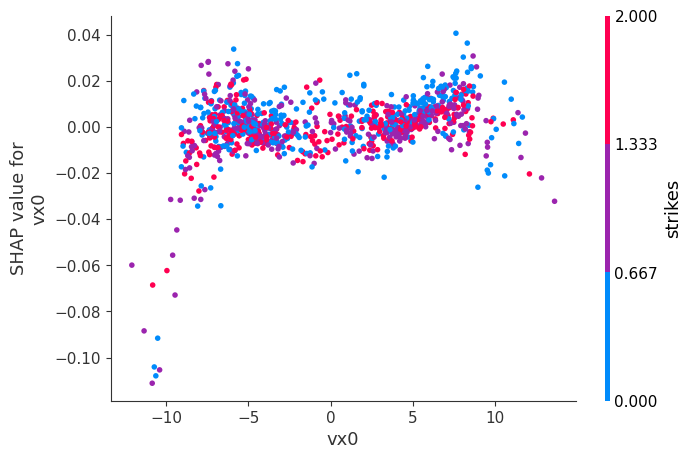

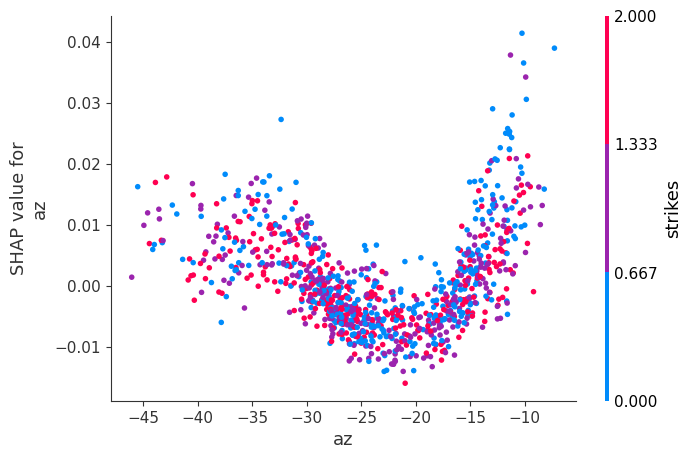

In [19]:
shap.dependence_plot("vx0", shap_values_rf[:, :, 3], X_test_final.iloc[:1000, :], interaction_index= "strikes")

shap.dependence_plot("az", shap_values_rf[:,:,3], X_test_final.iloc[:1000, :], interaction_index= "strikes")

In [20]:
shap.initjs()
display(shap.force_plot(explainer_rf.expected_value[3], shap_values_rf[10, :, 3], X_test_final.iloc[10]))

In [21]:
joblib.dump(explainer_rf, os.path.join(artifacts_dir, "explainer_rf.joblib"))

['C:\\Users\\lenov\\OneDrive\\Bureau\\mlops_interpretability\\artifacts\\explainer_rf.joblib']

In [23]:
import numpy as np
parent_dir = os.path.dirname(os.getcwd())  # remonte d'un niveau depuis notebooks

# chemin vers le dossier data
data_dir = os.path.join(parent_dir, "data")

# nom du fichier à créer
file_path = os.path.join(data_dir, "shap_values_rf.npy")

# sauvegarde du numpy array
np.save(file_path, shap_values_rf)

print(f"SHAP values sauvegardées dans : {file_path}")


SHAP values sauvegardées dans : C:\Users\lenov\OneDrive\Bureau\mlops_interpretability\data\shap_values_rf.npy


# Interprétabilité XGboost

In [25]:
import shap

explainer_xgb = shap.TreeExplainer(xgb_model, data = X_train_final.iloc[:3000, :] , 
                                 feature_perturbation='interventional')


In [26]:
shap_values = explainer_xgb.shap_values(X_test_final.iloc[:1000, :])

print(type(shap_values))

100%|===================| 3995/4000 [14:30<00:01]        

<class 'numpy.ndarray'>


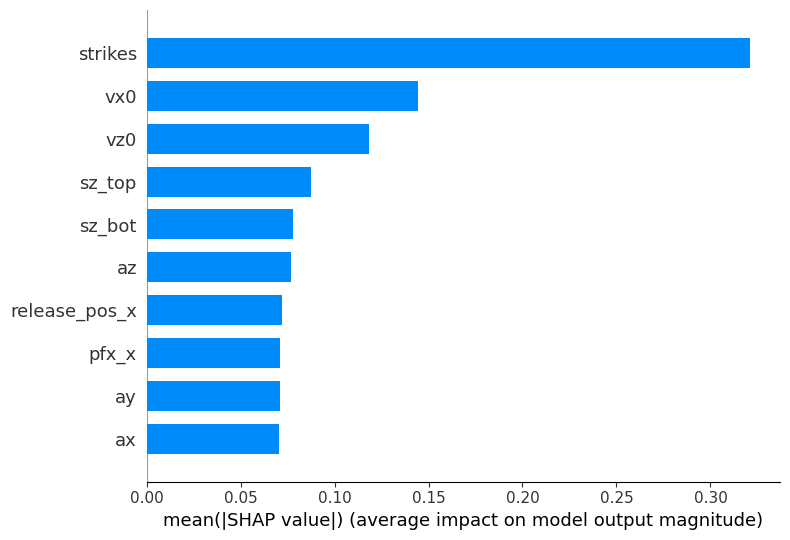

In [27]:
shap.summary_plot(shap_values[:, :, 3], X_test_final, plot_type="bar", max_display=10)

Variable	Description
> **vx0**	Vitesse de la balle selon l’axe x (horizontal latéral), en feet/sec.
> **vy0**	Vitesse de la balle selon l’axe y (longitudinal, direction home plate), en feet/sec.
> **vz0**	Vitesse de la balle selon l’axe z (vertical), en feet/sec.

Ces vitesses sont mesurées au moment du release, avant que la balle subisse gravité et spin.

2️⃣ Accélérations
> **ax**	Accélération sur l’axe x (lateral movement), feet/sec².
> **ay**	Accélération sur l’axe y (vers le home plate), feet/sec².
> **az**	Accélération sur l’axe z (verticale), feet/sec².

> **pfx_x**   Déviation latérale de la balle par rapport à une trajectoire linéaire (feet).

> **sz_top**	Hauteur maximale de la zone de strike du batteur (en feet) par rapport au sol.
> **sz_bot**	Hauteur minimale de la zone de strike du batteur (en feet) par rapport au sol.

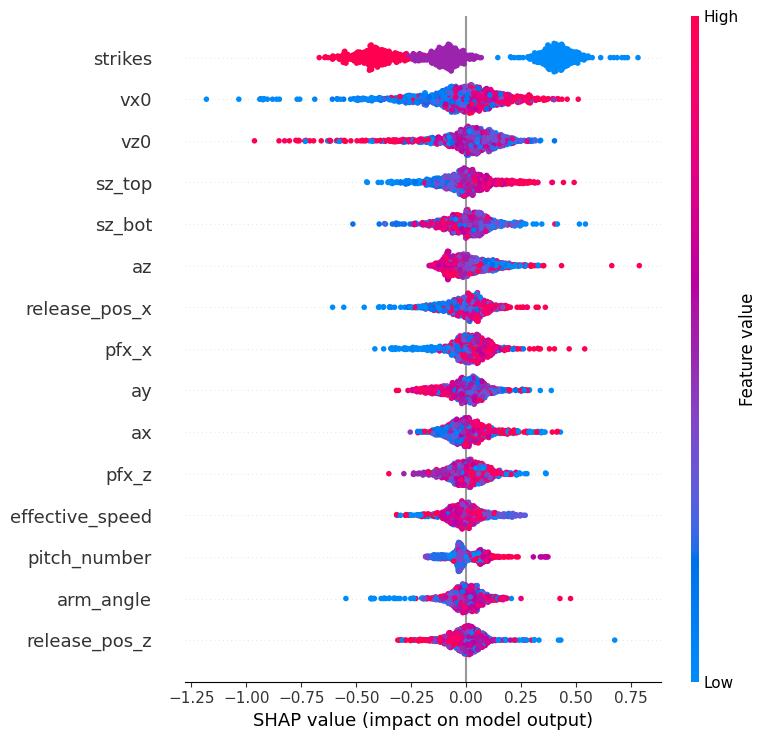

In [17]:
shap.summary_plot(shap_values[:, :, 3], X_test_final.iloc[:1000, :], feature_names=X_train_final.columns, max_display=15)

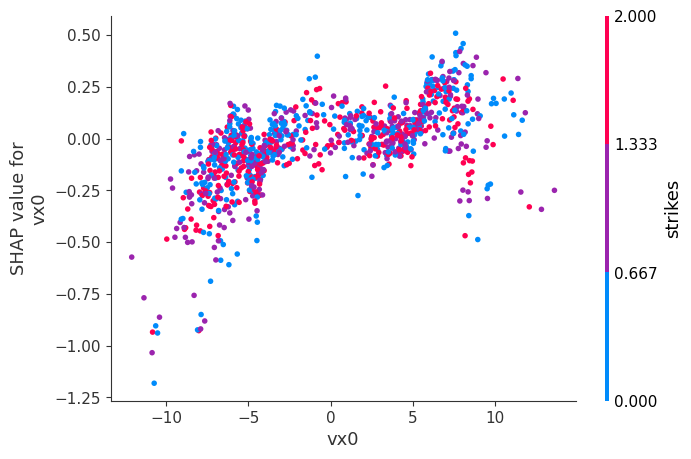

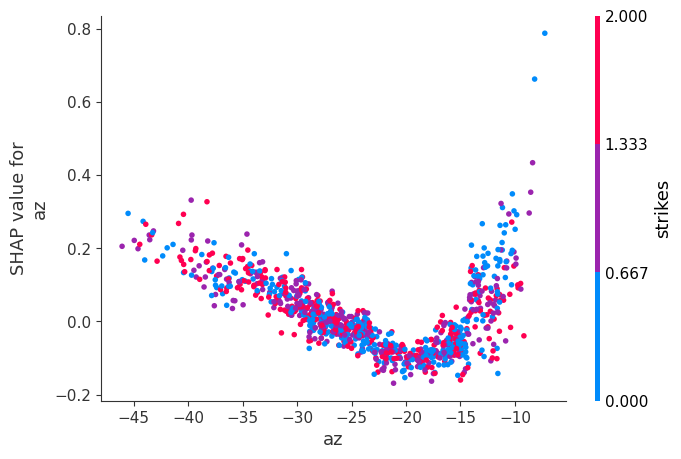

In [28]:
shap.dependence_plot("vx0", shap_values[:, :, 3], X_test_final.iloc[:1000, :], interaction_index= "strikes")

shap.dependence_plot("az", shap_values[:,:,3], X_test_final.iloc[:1000, :], interaction_index= "strikes")

In [29]:
shap.initjs()
display(shap.force_plot(explainer_xgb.expected_value[3], shap_values[10, :, 3], X_test_final.iloc[10]))

In [30]:
joblib.dump(explainer_xgb, os.path.join(artifacts_dir, "explainer_xgb.joblib"))

['C:\\Users\\lenov\\OneDrive\\Bureau\\mlops_interpretability\\artifacts\\explainer_xgb.joblib']

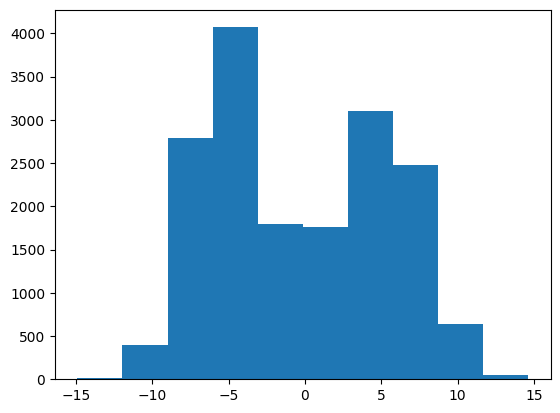

In [36]:
import matplotlib.pyplot as plt
plt.hist(X_train_final.vx0);

In [37]:
file_path = os.path.join(data_dir, "shap_values_xgb.npy")

# sauvegarde du numpy array
np.save(file_path, shap_values)

print(f"SHAP values sauvegardées dans : {file_path}")


SHAP values sauvegardées dans : C:\Users\lenov\OneDrive\Bureau\mlops_interpretability\data\shap_values_xgb.npy
